In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_recall_curve
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [4]:
df = pd.read_csv('..\\data\\processed\\train_HR_Analytics.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43846 entries, 0 to 43845
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           43846 non-null  int64  
 1   department            43846 non-null  object 
 2   region                43846 non-null  object 
 3   education             41897 non-null  object 
 4   gender                43846 non-null  object 
 5   recruitment_channel   43846 non-null  object 
 6   no_of_trainings       43846 non-null  int64  
 7   age                   43846 non-null  int64  
 8   previous_year_rating  40543 non-null  float64
 9   length_of_service     43846 non-null  int64  
 10  KPIs_met >80%         43846 non-null  int64  
 11  awards_won?           43846 non-null  int64  
 12  avg_training_score    43846 non-null  int64  
 13  is_promoted           43846 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 4.7+ MB


In [6]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,43253,Sales & Marketing,region_19,Bachelor's,m,other,1,31,5.0,5,1,0,48,0
1,67983,Technology,region_13,Master's & above,m,sourcing,1,34,1.0,4,0,0,78,0
2,17959,Technology,region_22,Bachelor's,m,other,3,29,4.0,4,1,0,77,0
3,50522,Sales & Marketing,region_2,Master's & above,m,other,1,54,4.0,15,1,0,47,1
4,62721,R&D,region_7,Bachelor's,m,sourcing,1,31,5.0,6,0,0,86,0


In [7]:
df['is_promoted'].value_counts()

0    40086
1     3760
Name: is_promoted, dtype: int64

### We can see that dataset is imbalanced. Only 8.5% data contains promoted class as true.

In [21]:
4668/(50140 + 4668) * 100

8.517004816815064

### check for null values

In [9]:
null_series = df.isnull().sum()
df.isnull().sum()

employee_id                0
department                 0
region                     0
education               1949
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    3303
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [10]:

null_cols = null_series[null_series > 0].index
null_cols

Index(['education', 'previous_year_rating'], dtype='object')

In [11]:
df['education'].value_counts()

Bachelor's          29347
Master's & above    11910
Below Secondary       640
Name: education, dtype: int64

In [12]:
df['previous_year_rating'].value_counts()

3.0    14933
5.0     9391
4.0     7870
1.0     4991
2.0     3358
Name: previous_year_rating, dtype: int64

In [13]:
df['recruitment_channel'].value_counts()

other       24312
sourcing    18621
referred      913
Name: recruitment_channel, dtype: int64

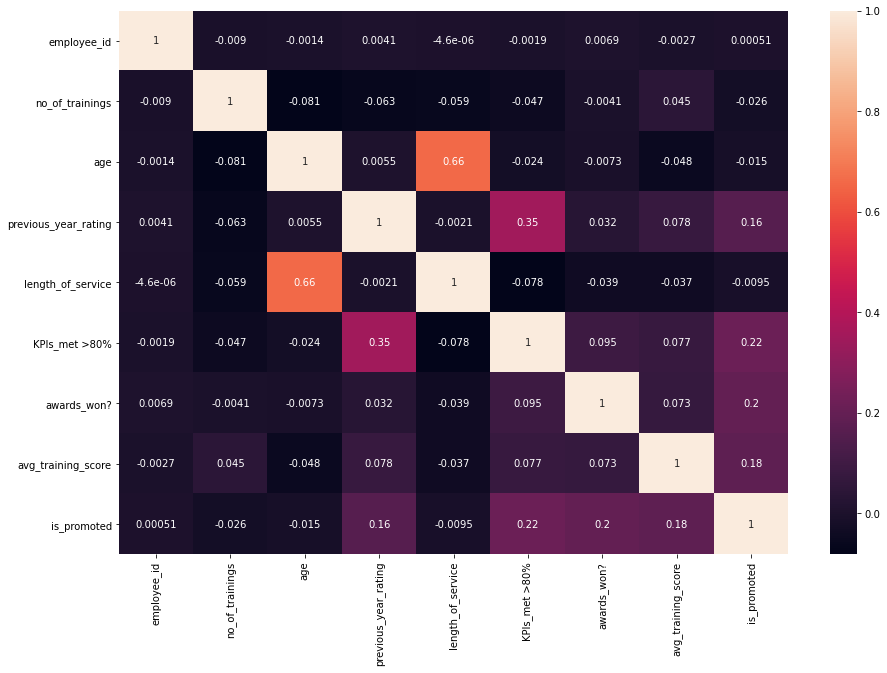

In [14]:
fig = plt.gcf()
fig.set_size_inches(15,10)
sns.heatmap(df.corr(), annot=True)
plt.show()

### Average training score, KPI met, awards won has more relation with promotion.

In [42]:
df.describe()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [15]:
cat_features = []
num_features = []
for col in df.columns:
    if (df[col].dtype =='O'):
        cat_features.append(col)
    else:
        if (df[col].unique().size > 10):
            num_features.append(col)
        else:
            cat_features.append(col)

In [16]:
cat_features

['department',
 'region',
 'education',
 'gender',
 'recruitment_channel',
 'no_of_trainings',
 'previous_year_rating',
 'KPIs_met >80%',
 'awards_won?',
 'is_promoted']

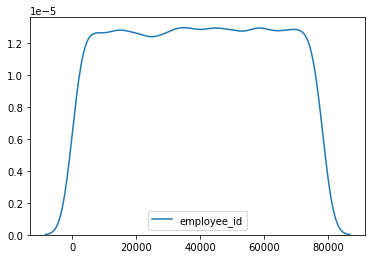

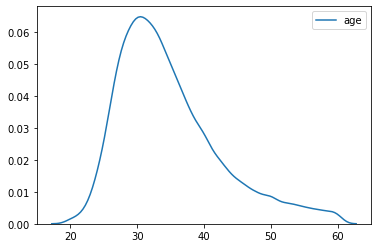

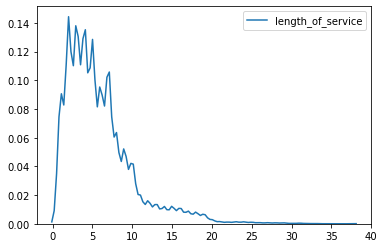

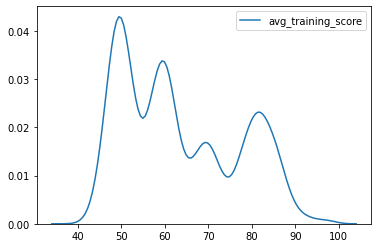

In [17]:
for col in num_features:
    sns.kdeplot(df[col])
    plt.show()

In [18]:
skew_data = df[num_features].skew(axis = 0, skipna = True)
asa = []
asa = skew_data[skew_data > 1.1].index.values
asa

array(['length_of_service'], dtype=object)

### We can see length of service has large skewness. So we can try log transformation on it.

In [109]:
# checking if lenght of service has any values less than 1.
df[df['length_of_service'] < 1]

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted


In [19]:
df['log_length_of_service'] = np.log(df['length_of_service'])

In [20]:
df['log_length_of_service'].skew(axis = 0, skipna = True)

-0.2877129572506811

In [21]:

df_new = df.copy()

### Calculating new features that can give better results.
### *. Calculating average training score and KPI group by region and department.

In [22]:
df_region_depart_mean_train_score = df_new.groupby(['region', 'department'])['avg_training_score'].agg('mean').unstack()

In [23]:
df_region_depart_mean_train_score

department,Analytics,Finance,HR,Legal,Operations,Procurement,R&D,Sales & Marketing,Technology
region,,,,,,,,,
region_1,84.763636,59.666667,50.250000,63.000000,59.765957,69.933333,NaN,51.144366,79.910714
region_10,84.904762,59.700000,50.833333,NaN,59.462687,70.064000,87.500000,49.888325,79.989362
region_11,84.617647,59.865385,49.448276,59.222222,60.073913,69.615942,83.600000,49.804734,79.751938
region_12,84.428571,59.714286,50.428571,64.250000,60.058824,70.423077,83.500000,51.197080,79.724138
region_13,84.773585,60.714286,49.367647,58.884615,60.213457,70.208589,85.100000,50.608458,79.936508
region_14,84.972973,59.772727,50.416667,NaN,59.487179,70.413793,86.500000,50.456000,79.654321
region_15,84.571429,59.424242,50.160714,61.062500,60.260483,70.560554,85.037037,49.865782,80.585799
region_16,84.280000,59.578947,49.444444,60.571429,60.650862,69.367470,84.300000,50.102345,80.121212
region_17,83.954545,NaN,49.000000,63.000000,60.974026,70.365672,83.000000,49.940789,79.881720


In [24]:
def calculate_train_score_wrt_reg_and_depart(x):
    return x['avg_training_score']/df_region_depart_mean_train_score.loc[x['region']][x['department']]

df_new['avg_train_score_gby_reg_dep'] = df_new.apply(calculate_train_score_wrt_reg_and_depart, axis=1)

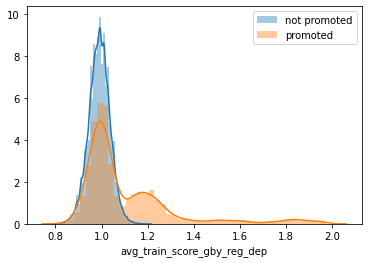

In [27]:
sns.distplot(df_new[df_new['is_promoted'] == 0]['avg_train_score_gby_reg_dep'], label = 'not promoted')
sns.distplot(df_new[df_new['is_promoted'] == 1]['avg_train_score_gby_reg_dep'], label='promoted');
plt.legend()
plt.show()

### This helped in distinguishing the promoted and not promoted ones

In [28]:
train, test = train_test_split(df, test_size= 0.2, random_state = 42)

In [29]:
X_train = train.drop('is_promoted', axis=1)
y_train = train['is_promoted']
X_test = test.drop('is_promoted', axis=1)
y_test = test['is_promoted']

In [30]:
print(X_train.shape, X_test.shape)

(35076, 14) (8770, 14)


In [26]:
class CalculateNewFeature():
    
    def __init__(self):
        self.df_region_depart_mean_score = pd.DataFrame()
        self.df_region_depart_KPI_avg_score = pd.DataFrame()
        self.df_region_depart_awards_won = pd.DataFrame()
    
    def fit(self, x_dataset, y=None):
        #self.df_region_depart_mean_score = x_dataset.groupby(['region', 'department'])['avg_training_score'].agg('mean').unstack()
        #self.df_region_depart_los_mean_score = x_dataset.groupby(['region', 'department'])['length_of_service'].agg('mean').unstack()
        return self

    def calculate_score_wrt_reg_and_depart(self, x):
        return x['avg_training_score']/self.df_region_depart_mean_score.loc[x['region']][x['department']]

    def calculate_df_region_depart_KPI_avg_score(self, x):
        if self.df_region_depart_KPI_avg_score.loc[x['region']][x['department']] == 0:
            return 0
        
        return x['KPIs_met >80%']/self.df_region_depart_KPI_avg_score.loc[x['region']][x['department']]
    
    def calculate_df_region_depart_awards_won(self, x):
        try:
            return x['awards_won?']/self.df_region_depart_awards_won.loc[x['region']][x['department']]
        except:
            return 0
    
    def transform(self, x_dataset, y=None):
        self.df_region_depart_mean_score = x_dataset.groupby(['region', 'department'])['avg_training_score'].agg('mean').unstack()
        self.df_region_depart_KPI_avg_score = x_dataset.groupby(['region', 'department'])['KPIs_met >80%'].agg('mean').unstack()
        self.df_region_depart_awads_won = x_dataset.groupby(['region', 'department'])['awards_won?'].agg('mean').unstack()
        x_dataset = x_dataset.assign(avg_test_score_gby_reg_dep = x_dataset.apply(self.calculate_score_wrt_reg_and_depart, axis=1))
        x_dataset = x_dataset.assign(KPIs_score_gby_reg_dep = x_dataset.apply(self.calculate_df_region_depart_KPI_avg_score, axis=1))
        x_dataset = x_dataset.assign(awards_won_gby_reg_dep = x_dataset.apply(self.calculate_df_region_depart_awards_won, axis=1))
        a = pd.DataFrame(StandardScaler().fit_transform(x_dataset[['avg_test_score_gby_reg_dep', 'KPIs_score_gby_reg_dep']]) , columns=['avg_test_score_gby_reg_dep', 'KPIs_score_gby_reg_dep'])
        a['KPI_and_training_Score'] = a['avg_test_score_gby_reg_dep']+a['KPIs_score_gby_reg_dep'] 
        x_dataset = x_dataset.join(a['KPI_and_training_Score']) 
        return x_dataset
    

In [31]:
class Scale():
    
    def __init__(self):
        self.minmax_scale = MinMaxScaler()
    
    def fit(self, x_dataset, y=None):
        self.minmax_scale.fit(x_dataset)
        return self

    def transform(self, x_dataset, y=None):
        return self.minmax_scale.transform(x_dataset)

In [32]:
class Impute_Missing_Data():
    
    def __init__(self, cat_var, num_var):
        self.cat_var = cat_var
        self.num_var = num_var
        self.sin = SimpleImputer(strategy='mean')
        self.sic = SimpleImputer(strategy='most_frequent')
    
    def fit(self, x_dataset, y=None):
        self.sic.fit(x_dataset[self.cat_var])
        self.sin.fit(x_dataset[self.num_var])
        return self

    def transform(self, x_dataset, y=None):
        x_dataset.loc[:][self.cat_var] = self.sic.transform(x_dataset[self.cat_var])
        x_dataset.loc[:][self.num_var] = self.sin.transform(x_dataset[self.num_var])
        x_dataset['KPI_and_training_Score'].fillna(value=0, inplace=True)
        #x_dataset['awards_won_gby_reg_dep'].fillna(value=0, inplace=True)
        return x_dataset

In [33]:
pre_process = ColumnTransformer(remainder='passthrough', 
                                transformers=[
                                              ('one_hot_encoding', ce.OneHotEncoder(), ['gender','education','recruitment_channel']),
                                              #('binary_encoding', ce.BinaryEncoder(), ['department', 'region']),
                                              ('drop_col', 'drop', [ 'gender', 
                                                                    'employee_id', 'recruitment_channel',
                                                                    'avg_training_score', 'education','department', 
                                                                    'region', 'KPIs_score_gby_reg_dep', 'KPIs_met >80%'])
                                             ])

In [34]:
num_var = ['previous_year_rating']
cat_var = ['education']

In [37]:
pip = Pipeline(steps=[('calculate_new_feature', CalculateNewFeature()),
                     ('impute_missing', Impute_Missing_Data(cat_var=cat_var, num_var=num_var)),
                     ('pre_process', pre_process),
                     ('scale', Scale()),
                     ('random_forest', RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=6))
                     ])

In [38]:
parameters = {
    'random_forest__n_estimators':[800,900,1000],
    'random_forest__max_depth':[4,5,6],
}

In [39]:
gcv = GridSearchCV(pip, parameters, cv=5, verbose=1)

In [40]:
pip.fit(X_train, y_train)

Pipeline(steps=[('calculate_new_feature',
                 <__main__.CalculateNewFeature object at 0x000001BD915EE670>),
                ('impute_missing',
                 <__main__.Impute_Missing_Data object at 0x000001BD915EE0D0>),
                ('pre_process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoding',
                                                  OneHotEncoder(),
                                                  ['gender', 'education',
                                                   'recruitment_channel']),
                                                 ('drop_col', 'drop',
                                                  ['gender', 'employee_id',
                                                   'recruitment_channel',
                                                   'avg_training_score',
                                                   'education', 'department',
               

In [41]:
pred_prob = pip.predict_proba(X_test)

In [42]:
for th in range(0, 110, 10):
    y_pred_th = (pred_prob[:,0] <= (th/100)).astype('int')
    #print("accuracy for threshold : ", th/100, " : ", accuracy_score(y_test, y_pred_th))
    print("F1 score for threshold : " ,th/100, " : ", f1_score(y_test, y_pred_th))
    #print(confusion_matrix(y_test, y_pred_th))
    #print(classification_report(y_test, y_pred_th))

F1 score for threshold :  0.0  :  0.0
F1 score for threshold :  0.1  :  0.023904382470119518
F1 score for threshold :  0.2  :  0.27378190255220414
F1 score for threshold :  0.3  :  0.4451345755693582
F1 score for threshold :  0.4  :  0.4598168870803662
F1 score for threshold :  0.5  :  0.47437185929648246
F1 score for threshold :  0.6  :  0.48055832502492524
F1 score for threshold :  0.7  :  0.4883720930232558
F1 score for threshold :  0.8  :  0.5027522935779817
F1 score for threshold :  0.9  :  0.3556581986143187
F1 score for threshold :  1.0  :  0.15640109312591968


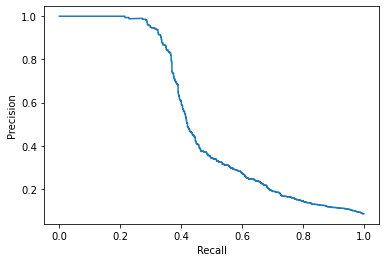

In [46]:
pre,rec,th = precision_recall_curve(y_test,pred_prob[:,1])
plt.plot(rec,pre)
plt.xlabel('Recall')
plt.ylabel('Precision');

### Trying undersampling

In [51]:
ros = RandomUnderSampler(sampling_strategy=0.55)
X_train_rus, y_train_rus = ros.fit_resample(X_train, y_train)

In [52]:
pip_us = Pipeline(steps=[('calculate_new_feature', CalculateNewFeature()),
                     ('impute_missing', Impute_Missing_Data(cat_var=cat_var, num_var=num_var)),
                     ('pre_process', pre_process),
                     ('scale', Scale()),
                     ('random_forest', RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=7))
                     ])

In [53]:
pip_us.fit(X_train_rus, y_train_rus)

Pipeline(steps=[('calculate_new_feature',
                 <__main__.CalculateNewFeature object at 0x000001BD96078DF0>),
                ('impute_missing',
                 <__main__.Impute_Missing_Data object at 0x000001BD9605DB20>),
                ('pre_process',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoding',
                                                  OneHotEncoder(),
                                                  ['gender', 'education',
                                                   'recruitment_channel']),
                                                 ('drop_col', 'drop',
                                                  ['gender', 'employee_id',
                                                   'recruitment_channel',
                                                   'avg_training_score',
                                                   'education', 'department',
               

In [54]:
pred_prob = pip_us.predict_proba(X_test)

In [56]:
for th in range(0, 110, 10):
    y_pred_th = (pred_prob[:,0] <= (th/100)).astype('int')
    #print("accuracy for threshold : ", th/100, " : ", accuracy_score(y_test, y_pred_th))
    print("F1 score for threshold : " ,th/100, " : ", f1_score(y_test, y_pred_th))
    #print(confusion_matrix(y_test, y_pred_th))
    #print(classification_report(y_test, y_pred_th))

F1 score for threshold :  0.0  :  0.0
F1 score for threshold :  0.1  :  0.29646017699115046
F1 score for threshold :  0.2  :  0.4523809523809524
F1 score for threshold :  0.3  :  0.461139896373057
F1 score for threshold :  0.4  :  0.4519155590304926
F1 score for threshold :  0.5  :  0.30095488969377676
F1 score for threshold :  0.6  :  0.17539463793535456
F1 score for threshold :  0.7  :  0.16340989601188438
F1 score for threshold :  0.8  :  0.16318228048367045
F1 score for threshold :  0.9  :  0.16015625
F1 score for threshold :  1.0  :  0.15640109312591968


In [57]:
y_train_ros.value_counts()

0    5483
1    3016
Name: is_promoted, dtype: int64

In [259]:
X_test.shape

(10962, 14)

### Trying Oversampling

In [58]:
from imblearn.over_sampling import SMOTE

In [59]:
smote = SMOTE(random_state=42,sampling_strategy=0.6)

In [60]:
pip_sm =  Pipeline(steps=[('calculate_new_feature', CalculateNewFeature()),
                     ('impute_missing', Impute_Missing_Data(cat_var=cat_var, num_var=num_var)),
                     ('pre_process', pre_process),
                     ('scale', Scale())
                     ])

In [61]:
X_train_smote = pip_sm.fit_transform(X_train)

In [63]:
x_smote, y_smote = smote.fit_resample(X_train_smote, y_train)

In [64]:
rf = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=7)

In [65]:
rf.fit(x_smote, y_smote)

RandomForestClassifier(max_depth=7, n_estimators=1000, random_state=42)

In [69]:
X_test_smote = pip_sm.transform(X_test)
pred_prob = rf.predict_proba(X_test_smote)
for th in range(0, 110, 10):
    y_pred_th = (pred_prob[:,0] <= (th/100)).astype('int')
    #print("accuracy for threshold : ", th/100, " : ", accuracy_score(y_test, y_pred_th))
    print("F1 score for threshold : " ,th/100, " : ", f1_score(y_test, y_pred_th))
    #print(confusion_matrix(y_test, y_pred_th))
    #print(classification_report(y_test, y_pred_th))

F1 score for threshold :  0.0  :  0.0
F1 score for threshold :  0.1  :  0.19782870928829915
F1 score for threshold :  0.2  :  0.46834170854271356
F1 score for threshold :  0.3  :  0.4918032786885245
F1 score for threshold :  0.4  :  0.5041398344066238
F1 score for threshold :  0.5  :  0.5095986038394414
F1 score for threshold :  0.6  :  0.3834519572953737
F1 score for threshold :  0.7  :  0.34044016506189817
F1 score for threshold :  0.8  :  0.19824046920821115
F1 score for threshold :  0.9  :  0.15776081424936386
F1 score for threshold :  1.0  :  0.15640109312591968


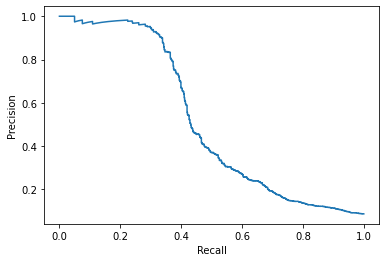

In [70]:
pre,rec,th = precision_recall_curve(y_test,pred_prob[:,1])
plt.plot(rec,pre)
plt.xlabel('Recall')
plt.ylabel('Precision');

In [71]:
parameters = {
    'gamma':[0.5,0.6,0.7,0.8],
    'n_estimators':[800,900,1000],
    'scale_pos_weight':[5,10,15,20]
}

In [ ]:
cv = GridSearchCV(XGBClassifier(learning_rate = 0.0480,max_depth = 10,min_child_weight = 2,random_state=42), 
                  parameters, cv=5, verbose=1)

In [74]:
clf = XGBClassifier(gamma = 0.5,learning_rate = 0.0480,max_depth = 10,min_child_weight = 2,n_estimators = 1000,
                    random_state=42, scale_pos_weight=5)

C:\Users\LPT-2517\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:40:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score for threshold :  0.1  :  0.47014925373134336
F1 score for threshold :  0.2  :  0.471882640586797
F1 score for threshold :  0.3  :  0.4703087885985747
F1 score for threshold :  0.4  :  0.46035242290748896
F1 score for threshold :  0.5  :  0.4442231075697211
F1 score for threshold :  0.6  :  0.4117647058823529
F1 score for threshold :  0.7  :  0.34954007884362687
F1 score for threshold :  0.8  :  0.29105839416058393
F1 score for threshold :  0.9  :  0.23146872416643702


C:\Users\LPT-2517\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:41:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score for threshold :  0.1  :  0.4839506172839506
F1 score for threshold :  0.2  :  0.49576783555018145
F1 score for threshold :  0.3  :  0.5
F1 score for threshold :  0.4  :  0.4921700223713646
F1 score for threshold :  0.5  :  0.46646646646646645
F1 score for threshold :  0.6  :  0.4210526315789474
F1 score for threshold :  0.7  :  0.37226733291692693
F1 score for threshold :  0.8  :  0.29888843145327293
F1 score for threshold :  0.9  :  0.2214369846878681


C:\Users\LPT-2517\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:42:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score for threshold :  0.1  :  0.48514851485148514
F1 score for threshold :  0.2  :  0.4951456310679612
F1 score for threshold :  0.3  :  0.5023696682464456
F1 score for threshold :  0.4  :  0.4926884139482565
F1 score for threshold :  0.5  :  0.47843942505133474
F1 score for threshold :  0.6  :  0.44158075601374563
F1 score for threshold :  0.7  :  0.3971166448230668
F1 score for threshold :  0.8  :  0.31478260869565217
F1 score for threshold :  0.9  :  0.22811001766338632


C:\Users\LPT-2517\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:44:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score for threshold :  0.1  :  0.46115288220551387
F1 score for threshold :  0.2  :  0.463803680981595
F1 score for threshold :  0.3  :  0.45933014354066976
F1 score for threshold :  0.4  :  0.464367816091954
F1 score for threshold :  0.5  :  0.4474789915966387
F1 score for threshold :  0.6  :  0.4056687333923827
F1 score for threshold :  0.7  :  0.34867141931302664
F1 score for threshold :  0.8  :  0.28880242109814097
F1 score for threshold :  0.9  :  0.22416812609457087


C:\Users\LPT-2517\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:45:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score for threshold :  0.1  :  0.44303797468354433
F1 score for threshold :  0.2  :  0.4527363184079602
F1 score for threshold :  0.3  :  0.4606060606060607
F1 score for threshold :  0.4  :  0.44935972060535506
F1 score for threshold :  0.5  :  0.4311632870864461
F1 score for threshold :  0.6  :  0.39180765805877116
F1 score for threshold :  0.7  :  0.35486063902107406
F1 score for threshold :  0.8  :  0.29977628635346754
F1 score for threshold :  0.9  :  0.23332474890548544


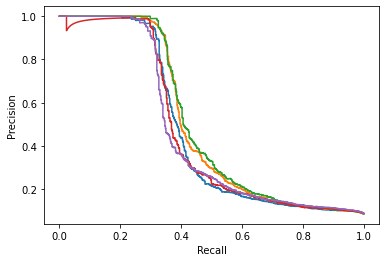

In [75]:
skf = StratifiedKFold(n_splits=5)

fold_no = 1

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold = X_train.iloc[train_index,:]
    X_test_fold = X_train.iloc[test_index,:]
    y_train_fold = y_train.iloc[train_index]
    y_test_fold = y_train.iloc[test_index]
    #print(test)
    
    X_train_ext= pip_sm.fit_transform(X_train_fold)
    X_test_ext= pip_sm.transform(X_test_fold)
    mod = clf.fit(X_train_ext,y_train_fold)
    pred = mod.predict_proba(X_test_ext)
    #keep prbabilities for possitive outcome only
    pre,rec,th = precision_recall_curve(y_test_fold,pred[:,1])
    plt.plot(rec,pre)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    for th in range(10, 100, 10):
        y_pred_th = (pred[:,0] <= (th/100)).astype('int')
        #print("accuracy for threshold : ", th/100, " : ", accuracy_score(y_test_fold, y_pred_th))
        print("F1 score for threshold : " ,th/100, " : ", f1_score(y_test_fold, y_pred_th))
        #print(confusion_matrix(y_test_fold, y_pred_th))
        #print(classification_report(y_test_fold, y_pred_th))
    fold_no += 1

In [76]:
X_test_boost = pip_sm.transform(X_test)
pred_prob = clf.predict_proba(X_test_boost)
for th in range(0, 110, 10):
    y_pred_th = (pred_prob[:,0] <= (th/100)).astype('int')
    #print("accuracy for threshold : ", th/100, " : ", accuracy_score(y_test, y_pred_th))
    print("F1 score for threshold : " ,th/100, " : ", f1_score(y_test, y_pred_th))
    #print(confusion_matrix(y_test, y_pred_th))
    #print(classification_report(y_test, y_pred_th))

F1 score for threshold :  0.0  :  0.0
F1 score for threshold :  0.1  :  0.45918367346938777
F1 score for threshold :  0.2  :  0.46906187624750495
F1 score for threshold :  0.3  :  0.4738878143133462
F1 score for threshold :  0.4  :  0.4691812327506899
F1 score for threshold :  0.5  :  0.4607594936708861
F1 score for threshold :  0.6  :  0.4333821376281113
F1 score for threshold :  0.7  :  0.37252747252747254
F1 score for threshold :  0.8  :  0.3
F1 score for threshold :  0.9  :  0.22483221476510068
F1 score for threshold :  1.0  :  0.15640109312591968


#### Roughly same results with Random forest and XGBoost. There is a high imbalance in class. Undersampling resulted in underfitting and oversampling resulted in overfitting.